# Fine-tuning koBERT on the University SDGS multi-class classification 

- *data_augmentation(Back-Translation)* 
- *split train/validation data*
- *load pretrained model*
- *fine-tuning on calssification task* 
- *test for new_data*


### Getting all the libraries + build the environment

In [ ]:
#구글드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- Python >= 3.6
- PyTorch >= 1.70
- Transformers = 3.0.2


In [ ]:
!pip install mxnet
!pip install gluonnlp pandas tqdm===4.63.2
!pip install sentencepiece
!pip install transformers==3.0.2
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49.1 MB 138 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 344 kB 4.2 MB/s 
     |████████████████████████████████| 76 kB 5.5 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595738 sha256=b86df0aca3d4633f9e5498ae3b8ff5babf3588c4e835d73093d113087c867133
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.64.1
    Uninstalling tqdm-4.64.1:
      Successfully uninstalled tqdm-4.64.1
Looking in indexes:

In [ ]:
#Load Pretrained Model : KoBERT
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-q4l_h7jr
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-q4l_h7jr
     |████████████████████████████████| 129 kB 4.3 MB/s 
     |████████████████████████████████| 54.7 MB 1.7 MB/s 
     |████████████████████████████████| 4.5 MB 40.3 MB/s 
     |████████████████████████████████| 1.2 MB 27.4 MB/s 
     |██████████████████████████████▎ | 834.1 MB 1.2 MB/s eta 0:00:41tcmalloc: large alloc 1147494400 bytes == 0x39eb4000 @  0x7faa67e8e615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     |████████████████████████████████| 881.9 MB 

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

#kobert
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

#GPU 사용
# device = torch.device("cuda:0")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#BERT 모델, Vocabulary 불러오기
bertmodel, vocab = get_pytorch_kobert_model()

/content/.cache/kobert_v1.zip[██████████████████████████████████████████████████]
/content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece[██████████████████████████████████████████████████]


In [ ]:
import seaborn as sns
import pandas as pd

### Getting datasets

In [ ]:
# 크롤링으로 수집한 대학의 SDGS활동 라벨 데이터 로드
df= pd.read_csv('preprocessed_kor.csv')  
df_ktextaug = df[['국가','대학교명','분류','영한_재번역']]
df_ktextaug

,국가,대학교명,분류,영한_재번역
0,영국,Leicester,1,Vostanis의 연구 (심리학) 교수는 특히 저소득 국가에 중점을 둔 아동 정신 ...
1,영국,Leicester,2,Leicester University Royal Botanic Gardens Kew...
2,영국,Leicester,3,Sally Singh 교수는 저소득 및 중간 소득 국가에서 적절한 폐 재활 프로그램...
3,영국,Leicester,4,런던에서 레스터 파트너십 제도는 학생 Polar 우편 번호를 기반으로 한 Great...
4,영국,Leicester,5,레스터 로스쿨 (Leicester Law School)의 Eugenia Caracc...
...,...,...,...,...
7065,영국,University of East Anglia,17,Aurora Students Organization UEA는 오로라 학생회의 현재 ...
7066,영국,University of East Anglia,17,SU 파트너십 우리의 SU는 여러 NGO 및 모든 사람들을위한 건강 포용성 및 번영...
7067,영국,University of East Anglia,17,운영 SDG Accord UEA는 2019 년부터 SDG Accord의 서명자였습니...
7068,영국,University of East Anglia,17,Aurora Sustainability Working Group Aurora Net...


In [ ]:
# 새로운 분류라벨 달아주기
SDGS = df_ktextaug['분류'].values
p5 = SDGS.tolist()
len(p5)

7070

In [ ]:
new_label=[]
for i in p5:
  if i in [1,2,3,4,5,6]:
    new_label.append(1)
  elif i in [7,12,13,14,15]:
    new_label.append(2)
  elif i in [8,9,10,11]:
    new_label.append(3)
  elif i in [16]:
    new_label.append(4)
  else:
    new_label.append(5)


In [ ]:
len(new_label)

7070

In [ ]:
new_lb = pd.DataFrame(new_label,columns=['new_label'])
new_lb

,new_label
0,1
1,1
2,1
3,1
4,1
...,...
7065,5
7066,5
7067,5
7068,5


In [ ]:
df_ktextaug['new_label'] = new_lb['new_label']

df_ktextaug

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,국가,대학교명,분류,영한_재번역,new_label
0,영국,Leicester,1,Vostanis의 연구 (심리학) 교수는 특히 저소득 국가에 중점을 둔 아동 정신 ...,1
1,영국,Leicester,2,Leicester University Royal Botanic Gardens Kew...,1
2,영국,Leicester,3,Sally Singh 교수는 저소득 및 중간 소득 국가에서 적절한 폐 재활 프로그램...,1
3,영국,Leicester,4,런던에서 레스터 파트너십 제도는 학생 Polar 우편 번호를 기반으로 한 Great...,1
4,영국,Leicester,5,레스터 로스쿨 (Leicester Law School)의 Eugenia Caracc...,1
...,...,...,...,...,...
7065,영국,University of East Anglia,17,Aurora Students Organization UEA는 오로라 학생회의 현재 ...,5
7066,영국,University of East Anglia,17,SU 파트너십 우리의 SU는 여러 NGO 및 모든 사람들을위한 건강 포용성 및 번영...,5
7067,영국,University of East Anglia,17,운영 SDG Accord UEA는 2019 년부터 SDG Accord의 서명자였습니...,5
7068,영국,University of East Anglia,17,Aurora Sustainability Working Group Aurora Net...,5


### Data augmentation

BackTranslation 

In [ ]:
!pip uninstall googletrans
!pip install googletrans==4.0.0-rc1

from googletrans import Translator
from tqdm import tqdm 
import time

trans = Translator()

In [ ]:
# 전처리된 원문, 한국어, 재번역 데이터 로드 
df_pp = pd.read_csv('retrans_final.csv')

In [ ]:
# 추가적인 영어 원문 전처리 

from gc import enable
# 줄바꿈 제거 
df['내용']= df['내용'].str.replace(pat=r'\n',repl=r' ',regex=True)


#url 제거
 # http로 시작되는 url
 # http로 시작되지 않는 url
df['내용']= df['내용'].str.replace(pat=r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',repl=r' ',regex=True)
df['내용']= df['내용'].str.replace(pat=r'[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{2,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)',repl=r' ',regex=True)

# 공백 두칸 한칸으로 붙이기
df['내용']= df['내용'].str.replace(pat=r'  ',repl=r' ',regex=True)

In [ ]:
df_pp

en-ja-ko BackTranslation 
 - 전처리된 데이터의 '내용' column 가져와서 English -> Japanese -> Korean으로 데이터 변형

In [ ]:
clean_text=[]
for s in df['내용']:
    clean_text.append(s)

In [ ]:
import time

#en-ja-ko

jako= []

for i in tqdm(clean_text):
  
  result = trans.translate(i, src = 'auto', dest='ja')
  time.sleep(0.6)
  result = trans.translate(result.text, src = 'ja', dest='ko')
  
  jako.append(result.text)

In [ ]:
jako[:5]

In [ ]:
#Back Translation완료된 데이터 가져와서 기존 훈련데이터에 합쳐주기 

BT_jp = pd.read_csv('jako_BackTrans.csv',index_col=0)
BT_jp.rename(columns = {'jako':'번역_jp'},inplace=True)
BT_jp
 

BT_jp = BT_jp.reset_index()
BT_jp.drop(BT_jp.tail(246).index,inplace=True)
BT_jp= BT_jp.drop(['index'],axis=1)
BT_jp

,번역_jp,분류
0,보스타니스 교수의 연구 (심리학)는 특히 저소득 국가에서 아동 정신 건강에 대한 외...,1
1,"지속 가능한 작물 개발을 개선하기위한 이니셔티브는 레스터 대학교, 왕립 식물원, Q...",2
2,Sally Singh 교수는 Richarging에게 저소득 및 중간 소득 국가에서 ...,3
3,런던에서 레스터까지의 파트너십 제도는 학생 Polar3의 우편 규범을 기반으로 런던...,4
4,Leicester Law School 박사 Dr. Karakchoro di Trel...,5
...,...,...
7065,오로라의 학생 조직 UEA는 오로라 학생회의 현재 사법 기관입니다.이 그룹은 Aur...,17
7066,SU 파트너십 우리의 SU는 모든 NGO 및 영향력있는 조직과의 파트너십을 통해 모...,17
7067,운영 SDG Accord UEA는 2019 년부터 SDG Accord 서명자였습니다...,17
7068,Aurora Network Aurora Sustainability Working G...,17


기존 데이터와 합쳐주기 

- '영한 재번역' = 크롤링한 원문데이터에 대해 번역후 전처리한 데이터
- '번역_JP' = '영한 재번역'데이터를 BackTranslation을 사용하여 증강한 데이터 (영-일-한) 

In [ ]:
# original data load
df = df_ktextaug

# 가로로 concat 해주기 
df = df[['영한_재번역','new_label']]

# 최종적으로 선택된 증강데이터 합쳐주기 
df['번역_jp'] = BT_jp['번역_jp']

#converting datatype
df['new_label']=df['new_label']-1
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,영한_재번역,new_label,번역_jp
0,Vostanis의 연구 (심리학) 교수는 특히 저소득 국가에 중점을 둔 아동 정신 ...,0,보스타니스 교수의 연구 (심리학)는 특히 저소득 국가에서 아동 정신 건강에 대한 외...
1,Leicester University Royal Botanic Gardens Kew...,0,"지속 가능한 작물 개발을 개선하기위한 이니셔티브는 레스터 대학교, 왕립 식물원, Q..."
2,Sally Singh 교수는 저소득 및 중간 소득 국가에서 적절한 폐 재활 프로그램...,0,Sally Singh 교수는 Richarging에게 저소득 및 중간 소득 국가에서 ...
3,런던에서 레스터 파트너십 제도는 학생 Polar 우편 번호를 기반으로 한 Great...,0,런던에서 레스터까지의 파트너십 제도는 학생 Polar3의 우편 규범을 기반으로 런던...
4,레스터 로스쿨 (Leicester Law School)의 Eugenia Caracc...,0,Leicester Law School 박사 Dr. Karakchoro di Trel...
...,...,...,...
7065,Aurora Students Organization UEA는 오로라 학생회의 현재 ...,4,오로라의 학생 조직 UEA는 오로라 학생회의 현재 사법 기관입니다.이 그룹은 Aur...
7066,SU 파트너십 우리의 SU는 여러 NGO 및 모든 사람들을위한 건강 포용성 및 번영...,4,SU 파트너십 우리의 SU는 모든 NGO 및 영향력있는 조직과의 파트너십을 통해 모...
7067,운영 SDG Accord UEA는 2019 년부터 SDG Accord의 서명자였습니...,4,운영 SDG Accord UEA는 2019 년부터 SDG Accord 서명자였습니다...
7068,Aurora Sustainability Working Group Aurora Net...,4,Aurora Network Aurora Sustainability Working G...


In [ ]:
df

,영한_재번역,new_label,번역_jp
0,Vostanis의 연구 (심리학) 교수는 특히 저소득 국가에 중점을 둔 아동 정신 ...,0,보스타니스 교수의 연구 (심리학)는 특히 저소득 국가에서 아동 정신 건강에 대한 외...
1,Leicester University Royal Botanic Gardens Kew...,0,"지속 가능한 작물 개발을 개선하기위한 이니셔티브는 레스터 대학교, 왕립 식물원, Q..."
2,Sally Singh 교수는 저소득 및 중간 소득 국가에서 적절한 폐 재활 프로그램...,0,Sally Singh 교수는 Richarging에게 저소득 및 중간 소득 국가에서 ...
3,런던에서 레스터 파트너십 제도는 학생 Polar 우편 번호를 기반으로 한 Great...,0,런던에서 레스터까지의 파트너십 제도는 학생 Polar3의 우편 규범을 기반으로 런던...
4,레스터 로스쿨 (Leicester Law School)의 Eugenia Caracc...,0,Leicester Law School 박사 Dr. Karakchoro di Trel...
...,...,...,...
7065,Aurora Students Organization UEA는 오로라 학생회의 현재 ...,4,오로라의 학생 조직 UEA는 오로라 학생회의 현재 사법 기관입니다.이 그룹은 Aur...
7066,SU 파트너십 우리의 SU는 여러 NGO 및 모든 사람들을위한 건강 포용성 및 번영...,4,SU 파트너십 우리의 SU는 모든 NGO 및 영향력있는 조직과의 파트너십을 통해 모...
7067,운영 SDG Accord UEA는 2019 년부터 SDG Accord의 서명자였습니...,4,운영 SDG Accord UEA는 2019 년부터 SDG Accord 서명자였습니다...
7068,Aurora Sustainability Working Group Aurora Net...,4,Aurora Network Aurora Sustainability Working G...


In [ ]:
#check datatype of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7070 entries, 0 to 7069
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   영한_재번역     7070 non-null   object
 1   new_label  7070 non-null   int64 
 2   번역_jp      7070 non-null   object
dtypes: int64(1), object(2)
memory usage: 165.8+ KB


### split training - test set
method 1 = conveying the ratio of original dataset



분포 확인

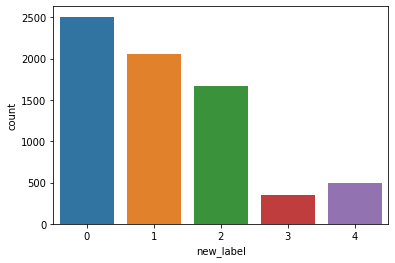

In [ ]:
#ratio of each columns
import seaborn as sns
sns.countplot(x = df['new_label'])

- 데이터 스플릿 (랜덤으로 뽑아놓고 나머지 섞어서 트레인데이터 만들기)

- 기존 라벨분포와 동일하게 랜덤으로 750개 데이터를 추출해서 test셋으로 제작 

In [ ]:
#ratio of each label
ratio = (df.groupby("new_label").size()/df.groupby("new_label").size().sum()).to_frame('ratio')

#number of data we need to sample for each label
ratio['number'] = round(ratio['ratio']*750).astype(int)

ratio

,ratio,number
new_label,,
0,0.354455,266
1,0.290806,218
2,0.235361,177
3,0.049788,37
4,0.069590,52


In [ ]:
#creating test dataset
test = pd.DataFrame()

for i in range(5):
  sample = df.loc[df['new_label'] == i].sample(n=ratio['number'][i]) # random_state = 11로 시드설정 가능 
  test = pd.concat([test,sample])

# test = test[['영한_재번역','new_label']]
test

,영한_재번역,new_label,번역_jp
5129,홍콩의 도시 고형 폐기물의 약 40 는 음식물 쓰레기이며 일부 주민들은 여전히 ...,0,홍콩 고형 폐기물의 약 40 %는 음식물 쓰레기이지만 일부 주민들은 여전히 ​​기본...
5236,LSE Garrick과 Shaw Caf 는 Bronze Award를 수상한 반면 4...,0,LSE Garrick과 Shawcafé가 Bronze Award를 수상한 반면 Re...
1455,건축 환경의 학교 산업 설계 재 설계 - 원형 경제“새로운 산업 디자인 제품은 ...,0,건축 환경 : 산업 설계의 규정 -경제 경제 경제 경제 경제는 유엔의 지속 가능한 ...
4903,Australian Rivers Institute Australian Rivers ...,0,Australia Rivers Institute Australia Rivers In...
1041,자선 영향 RMIT는 모든 배경의 모든 학생들을위한 삶을 변화시키는 교육 경험을 창...,0,"자선 영향 RMIT는 모든 배경의 모든 학생들에게 삶을 변화시키고 삶, 일 및 학습..."
...,...,...,...
6521,케임브리지 파트너십 케임브리지 대학교와 아 쇼카 대학교 (Ashoka Univers...,4,케임브리지의 파트너십 Cambridge University와 Ashoka Unive...
5507,2017/18 년에 스턴 경은 모든 수준에서 정책 입안자들과 기후 변화에 대한 긴급...,4,2017/18 년에 Stern Lord는 모든 수준의 정책 계획가와 함께 기후 변화...
490,원주민 음악 Execs Global Music Company BMG는 교육 및 예술...,4,원주민 음악 Execs Global Music Company BMG는 Newcast...
4944,Caitline Byrne 교수가 이끄는 Griffith 's Asia Instit...,4,"2021 년, SDGS의 IIInternationAtrnerships는 아시아 그리..."


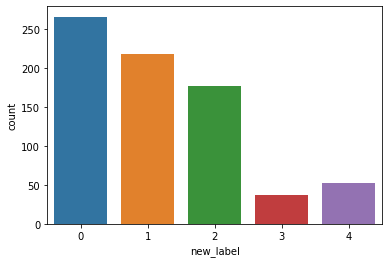

In [ ]:
# test셋 분포 확인
sns.countplot(x = test['new_label'])

# 기존 전체데이터의 라벨과 동일한 분포대로 test셋 

In [ ]:
# test셋에 사용한 데이터를 제외하고 나머지를 train_set으로 사용 

#creating train dataset
df = df.drop(test.index)
#shuffle the dataset
df = df.sample(frac=1)
df

,영한_재번역,new_label,번역_jp
6567,목표 4는“포용적이고 공평한 품질 교육을 보장하고 평생 학습 기회를 홍보하는 것”을...,0,"목표 4는 ""포괄적이고 공정한 품질의 교육을 안전하게하고 모든 사람을위한 평생 학습..."
6804,Cuhk는 연구 혁신 및 기업을 역동적이고 생산적인 연속체에 통합하려고합니다2021...,2,"CUHK는 연구, 혁신 및 회사를 역동적이고 생산적인 연속체로 통합하려고 노력하고 ..."
7056,Council for AT Risk Academics -Cara UEA는 Cara의...,3,Risk Academics의 협의회 -Cara UEA는 Cara의 회원이며 폭력의 ...
4882,Healthy Primary Care (HPC)는 2021 년 퀸즐랜드 젊은 키 큰...,0,Healthy Primary Care (HPC)는 Laurenball 부교수가 이끄...
1485,주택 경제성은 주요 도시와 지역 센터에서 계속 문제가되고 있습니다 지역 사회 주택 ...,2,저렴한 주택 가격은 주요 도시와 지역 센터에서 계속 문제가되고 있습니다. 지역 사회...
...,...,...,...
3370,- 109 개 이상의 연구 단위의 연구에 중점을 둡니다 '성별'및 기타 연구 단위가...,0,"-109 개 이상의 유닛에 대한 연구는 ""성별""에 중점을두고 다른 연구 유닛은 주제..."
5029,NTUSA (National Taiwan University Student Asso...,1,NTUSA (National Taiwan University Student Asso...
1086,지속 가능한 조달 RMIT RMIT는 공급망 및 파트너십이 인권 노동 환경 및 부패...,2,"지속 가능한 조달 RMIT는 우리의 공급망과 파트너십이 인권, 노동, 환경 및 부패..."
2333,Alma Mater는 Coimbra Group의 일부이며 특히 개발 협력의 실무 그...,4,"Alma Mater는 Coin Bra Group, 특히 개발 협력 그룹의 일부입니다..."


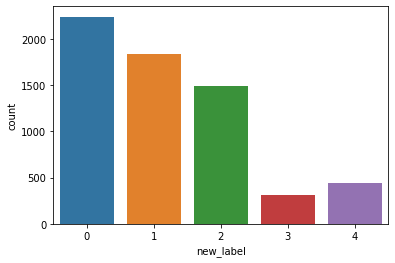

In [ ]:
# shuffle 된 train data  분포 확인 
sns.countplot(x = df['new_label'])


#### test set / train set check

- 모델에 입력으로 넣어주기 위해 리스트 형태로 각각 추출 
- split 비율 확인 

In [ ]:
#creating trainset manually
trainset = []

for sentence, label in zip(df['영한_재번역'], df['new_label']):
    data = []
    data.append(sentence)
    data.append(str(label))
    trainset.append(data)


for sentence, label in zip(df['번역_jp'], df['new_label']):
    data = []
    data.append(sentence)
    data.append(str(label))
    trainset.append(data)


In [ ]:
#creating testset manually
testset = []

for sentence, label in zip(test['영한_재번역'], test['new_label']):
    data = []
    data.append(sentence)
    data.append(str(label))
    testset.append(data)

In [ ]:
print(len(trainset))
print(len(testset))

12640
750


### model load

In [ ]:
#creating dataset suitable for BERT
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [ ]:
# Setting hyperparameters
max_len = 256
batch_size = 16
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [ ]:
#tokenize / padding
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

data_train = BERTDataset(trainset, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(testset, 0, 1, tok, max_len, True, False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
data_train[1000], data_test[0]

((array([   2,  637,  367,  401,  436,  409,  695,  425,  405,  454,  440,
          413,  458,  707,  637,  367,  401,  436,  409,  687,  389,  455,
          394,  367,  399,  389, 4465, 7178,  522,  517,  350,  333,  517,
           40,  695,  329,  270, 7095, 4924, 6629, 4465, 7186,  548,  244,
          517, 5717,  687,  367,  415,  401,  389,  394,  517, 7508, 6983,
         3762, 1916, 6903, 1138, 4852, 6633, 4619, 7789, 3567, 4845,  612,
          157,  423,  525, 3803, 7095, 4845, 5197, 7078, 2770, 2184,  885,
         5895, 6701, 6493, 7003, 1770, 4465, 1065, 7086, 2704, 6241, 7821,
         7202, 5133, 1770, 4743, 5561, 5144, 2948, 6037, 7318, 2982, 7100,
         7418, 1770, 4538, 4852, 6631, 4162, 5424, 2184, 1073, 5361, 3567,
         3969, 6493, 7003, 7789, 3567, 3990, 6641, 6903, 5100, 7842, 5906,
            3,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1

In [ ]:
#dataset for torch , DataLoader사용해 모델에 input할 수 있는 형태로 
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### padding 개수 확인해서 적절한 maxlen 설정하기

문장별 패딩 토큰의 개수를 고려하여 적절한 max_length를 설정해주기 

In [ ]:
print("max_len:",max_len)

b=[]
for i in range(len(trainset)):
  b.append(np.count_nonzero(data_train[i][0] == 1))

print(len(b))

# 평균 패딩 개수


num_zero = b.count(0)

for item in b:
    if item == 0:
        b.remove(0)
without_zero = len(b)

print("패딩 없는 요소 비율(max_len초과):",num_zero / (num_zero+without_zero) * 100, "%")

#평균 패딩

print("패딩있는 요소 비율:",len(b)/ (num_zero+len(b)) * 100, "%" )

print("평균 패딩 개수(max_len초과하지 않은 요소들에 대해서만):",sum(b)/len(b))

max_len: 256
12640
패딩 없는 요소 비율(max_len초과): 12.834890965732088 %
패딩있는 요소 비율: 87.16510903426791 %
평균 패딩 개수(max_len초과하지 않은 요소들에 대해서만): 129.4386168691923


### Model Training

In [ ]:
#BERT classifier
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=5,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [ ]:
#loading BERT model
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)



#optimizer / schedule
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

#multi-label 분류일경우
#loss_fn = nn.MultiLabelSoftMarginLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#calculate accuracy
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
    
train_dataloader

In [ ]:
#for plotting
train_accuracy = []
loss_ = []
test_accuracy = []

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
#train KoBERT
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device) 
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    train_accuracy.append(train_acc / (batch_id+1))
    loss_.append(loss.data.cpu().numpy().item())
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    test_accuracy.append(test_acc / (batch_id+1))
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))


  0%|          | 1/790 [00:00<07:44,  1.70it/s]

epoch 1 batch id 1 loss 0.006320289336144924 train acc 1.0


 25%|██▌       | 201/790 [01:22<04:01,  2.44it/s]

epoch 1 batch id 201 loss 0.0059454236179590225 train acc 0.9732587064676617


 51%|█████     | 401/790 [02:44<02:39,  2.43it/s]

epoch 1 batch id 401 loss 0.009018506854772568 train acc 0.9728802992518704


 76%|███████▌  | 601/790 [04:07<01:17,  2.43it/s]

epoch 1 batch id 601 loss 0.015293962322175503 train acc 0.9716098169717138


100%|██████████| 790/790 [05:24<00:00,  2.43it/s]


epoch 1 train acc 0.9719936708860759


100%|██████████| 47/47 [00:06<00:00,  7.02it/s]


epoch 1 test acc 0.7752659574468085


  0%|          | 1/790 [00:00<07:23,  1.78it/s]

epoch 2 batch id 1 loss 0.007155444473028183 train acc 1.0


 25%|██▌       | 201/790 [01:22<04:02,  2.43it/s]

epoch 2 batch id 201 loss 0.0037798660341650248 train acc 0.9704601990049752


 51%|█████     | 401/790 [02:44<02:39,  2.44it/s]

epoch 2 batch id 401 loss 0.021239900961518288 train acc 0.9716334164588528


 76%|███████▌  | 601/790 [04:06<01:17,  2.43it/s]

epoch 2 batch id 601 loss 0.007300614379346371 train acc 0.9708818635607321


100%|██████████| 790/790 [05:24<00:00,  2.43it/s]


epoch 2 train acc 0.971123417721519


100%|██████████| 47/47 [00:06<00:00,  7.01it/s]

epoch 2 test acc 0.7741261398176291


### 모델저장 / 저장된 모델 불러오기 

In [ ]:
#모델 저장하기 
# torch.save(model,'/content/drive/MyDrive/ESGBERT/new_label_77.pt')

In [ ]:
#저장된 모델 가져오기
# model = torch.load('/content/drive/MyDrive/ESGBERT/모델 저장/model_77_maxlen256_batch32.pt')

### Plotting accuracy & loss

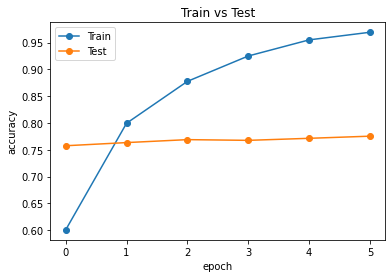

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_accuracy,'-o')
plt.plot(test_accuracy,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Test')
 
plt.show()

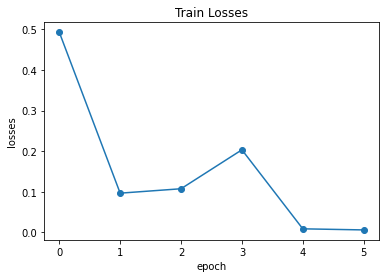

In [ ]:
plt.plot(loss_,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('Train Losses')
 
plt.show()

### 새로운 인풋 예측 함수 

predict 함수 정의해서 학습된 모델의 새로운 인풋에 대한 예측값을 나타내기 

In [ ]:
# 새로운 인풋 테스트
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)


        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 0:
                test_eval.append("1")
            elif np.argmax(logits) == 1:
                test_eval.append("2")
            elif np.argmax(logits) == 2:
                test_eval.append("3")
            elif np.argmax(logits) == 3:
                test_eval.append("4")
            elif np.argmax(logits) == 4:
                test_eval.append("5")






        return test_eval[0]

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
# logit값 뱉는 함수 설정 

tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

def logits(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)

        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()
        
        return logits

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
# sigmoid값 뱉는 함수 설정 
import math

def sigmoid(x):
    sig = 1 / (1 + math.exp(-x))
    return sig

tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

def logits(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)

        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()
        s = []
        for i in logits:
            sig = sigmoid(i)
            s.append(sig)
        return s

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


### 기존 학습데이터 우리가 학습시킨 모델로 멀티라벨 해주기

In [ ]:
#저장된 모델 가져오기
# model = torch.load('/content/drive/MyDrive/ESGBERT/model_79.pt')

# 테스트데이터 리스트로 바꿔주기
original = df['영한_재번역'].to_list()
print(original[0])

# 테스트데이터 정답
answer = df['new_label'].to_list()
print(answer[0])

Vostanis의 연구 (심리학) 교수는 특히 저소득 국가에 중점을 둔 아동 정신 건강에 대한 외상의 영향에 중점을 둡니다
0


In [ ]:
# 학습데이터 예측과 로짓값 출력 
pred_og=[]
sig=[]
for i in tqdm(original[3500:4500]):
  pred_og.append(predict(i))
  sig.append(logits(i))


  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 1000/1000 [12:41<00:00,  1.31it/s]


In [ ]:
print(sig[0])

[0.4452904653209439, 0.1935938236179643, 0.9928299576702263, 0.2077267010328128, 0.12206395079777368]


In [ ]:
pred_og=[]
sig2=[]
for i in tqdm(original[4500:5500]):
  pred_og.append(predict(i))
  sig2.append(logits(i))

100%|██████████| 1000/1000 [13:48<00:00,  1.21it/s]


In [ ]:
pred_og=[]
sig3=[]
for i in tqdm(original[5500:]):
  pred_og.append(predict(i))
  sig3.append(logits(i))

  0%|          | 0/1329 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 1329/1329 [21:29<00:00,  1.03it/s]


In [ ]:
sig = sig + sig2 + sig3

In [ ]:
# 정답을 알고있는 문제임에도 sigmoid값이 90이상인게 존재한다면 그건 중복라벨로 볼 수 있다는 가정

# 리스트내에 두번째 큰값 찾기 함수 정의 
def kth_largest_number(arr, K):
    unique_nums = set(arr)
    sorted_nums = sorted(unique_nums, reverse=True)
    return sorted_nums[K-1]


# 두번째 큰값의 라벨번호 찾기 함수
# def label_number


kth_largest_number(sig[2],2)

0.2768279724382876

In [ ]:
# 라벨정보를 가진 쌍리스트 생성
import tqdm


index_id = []
over_09 = []
for i in range(len(sig)):
  for j in range(5):
    if sig[i][j] >= 0.7: # 0.9가 넘는다면, 
      if sig[i][j] == kth_largest_number(sig[i],2): # 만약 0.9넘는값이 sig[i]중 두번째로 큰 값이라면 
        index_id.append(i) #인덱스 번호 들ㅇ어있는 리스트 
        over_09.append(j) # 라벨번호 들어있는 리스트 



In [ ]:
# print("인덱스번호:",index_id)
# print("중복라벨번호:",over_09)



# 0번인덱스에 가능한 중복라벨 0번 / 1번인덱스 로우에 가능한 중복라벨 4번 

# 길이확인
print(len(index_id))
print(len(over_09))

325
325


In [ ]:
#인덱스 번호에 해당하는 orginal data 불러오기

multi_data = []
for i in index_id:
  multi_data.append(original[i])

# multi data = index에 해당하는 로우의 텍스트 데이터 

In [ ]:
# 해당 텍스트와 중복라벨을 매핑한 데이터프레임 만들기 
df_multi_label = pd.DataFrame((zip(multi_data, over_09)), columns = ['멀티데이터', '멀티라벨'])
df_multi_label = df_multi_label.drop_duplicates()
df_multi_label

,멀티데이터,멀티라벨
0,Harjinder Sembhi 박사와 Darren Ghent 박사는 Earthlin...,0
1,연구 내에서‘탄력성 목회주의 랭 랜드의 지속 가능한 미래를 향해’이 대학은 케냐...,0
2,우리는 Stonewall의 Workplace Equality Index에서 100 ...,2
3,폐기물 관리에 대한 폐기물 접근 방식은 순환 경제 전망에 의해 뒷받침됩니다 이는 폐...,2
4,Nastro Verde의 첫 번째 판은 2019 년에 개최되었으며 전체 대학 공동체...,1
...,...,...
320,미래의 소비자 중심 에너지 세계에서 소비자는 더 이상 전력선의 끝에 있지 않을 것입...,1
321,Carrillo-Tudela 교수와 Essex와 Edinburgh Universit...,1
322,이를 통해 그들은 실업 및 불평등 계산기를 개발하여 공무원과 다른 사람들이 제안 된...,2
323,2016 년과 2019 년 1 월 사이 에이 프로그램은 2 백만 개가 넘는 저소득 ...,2


In [ ]:
answer = answer[:100]

wrong_list_test=[]
wrong2 = 0
for i in range(len(answer)):
  if answer[i] != pred_og[i]:
    wrong += 1
    wrong_list.append(str(answer[i]) + str(pred_og[i]))

In [ ]:
print("문제수:",len(pred_og))
print("틀린개수:",wrong2)

print("정답율:", (len(answer)-wrong2) / len(pred_og) )

문제수: 100
틀린개수: 0
정답율: 1.0


In [ ]:
# df_multi_label.to_csv('325중복라벨추가.csv')

### 국내대학 보고서로 model test 해보기 

In [ ]:
KOR_test = pd.read_csv('KOR_test.csv',index_col=0)
KOR_test = KOR_test.reset_index()

In [ ]:
SDGS_kor = KOR_test['분류'].values
p5_kor = SDGS_kor.tolist()
len(p5_kor)

315

In [ ]:
new_label_kor=[]
for i in p5_kor:
  if i in [1,2,3,4,5,6]:
    new_label_kor.append(1)
  elif i in [7,12,13,14,15]:
    new_label_kor.append(2)
  elif i in [8,9,10,11]:
    new_label_kor.append(3)
  elif i in [16]:
    new_label_kor.append(4)
  else:
    new_label_kor.append(5)

In [ ]:
new_lb_kor = pd.DataFrame(new_label_kor,columns=['new_label'])
new_lb_kor

,new_label
0,1
1,1
2,1
3,1
4,1
...,...
310,5
311,5
312,5
313,5


In [ ]:
KOR_test['new_label'] = new_lb_kor['new_label']
KOR_test

,index,분류,번역,new_label
0,1259,1,저소득층 학생을 위한 지원 ∙ 서울대학교에서는 저소득층 학생을 대상으로 등록금 장 ...,1
1,1260,2,구성원의 식사/기아 문제 해결 - “천원의 식사” ∙서울대학교에서는 재학생 대상으로...,1
2,1261,2,지속가능한 농업 지식/기술 제공 ∙농업생명과학대학에서는 지속가능농업 분야 관련 정규...,1
3,1262,3,"지역사회 건강과 복지 향상에 기여 ∙ 지역사회 공공 보건활동, 의과대학의 지역사회학...",1
4,1263,3,세계 보건기관과의 협력 서울대학교 병원 공공보건 의료사업단은 세계보건기구 (WHO)...,1
...,...,...,...,...
310,1667,17,특강을 통해 지역주민에게 기후변화의 위험에 대한 경각심 고취,5
311,1668,17,"학내 구성원 및 지역주민 대상 미술, 음악, 스포츠 등 다양한 분야의 교육과정 제공",5
312,1669,17,"학내 구성원 및 지역주민 대상 영어, 프랑스어, 중국어 등의 외국어 강좌 제공",5
313,1670,17,강원국제개발협력센터 뉴스레터에 SDG를 안내하여 구성원의 인식 제고,5


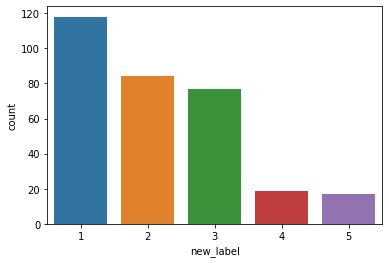

In [ ]:
# 국내대학 보고서(테스트용) 정답 분포 확인 
import seaborn as sns
sns.countplot(x = KOR_test['new_label'])

In [ ]:
# 번역만 떼서 predict에 집어넣기 



data_list2 = []
for data in KOR_test['번역']:
  data_list2.append(data)

data_list2[:2]

['저소득층 학생을 위한 지원 ∙ 서울대학교에서는 저소득층 학생을 대상으로 등록금 장 학금, 선한 인재 장학금, 해외 수학 장학금을 운영하 고 있으며, 2019년 1학기에는 13.5%의 재학생들이, 2학 기에는 17.2%의 재학생들이 재정 지원을 받았습니다. ∙ 저소득 가구 학생, 농어촌 학생, 장애인, 북한 이탈 주 민 등 소수자들은 기회균형 선발 특별전형으로 입학할 수 있습니다. 저소득층 학생은 입학 이후에 기숙사 입 주 신청 시 우선 선발 대상이 됩니다.',
 '구성원의 식사/기아 문제 해결 - “천원의 식사” ∙서울대학교에서는 재학생 대상으로 ‘천원의 식사’ 코너를 운영하여 저소득층 학생들의 식비 부담을 줄이고 건강 향상에 기여하고 있습니다. ‘천원의 식사’는 가격에 비해 양질의 식사를 제공하여 구성원에게 인기가 높습니다. 학교 생협 직영 식당 6개소에서는 건강하고 저렴한 음식을 제공하기 위해 구성원들에게 식비 가격을 기준 가격보다 할인해 주고 있습니다.']

In [ ]:
# predict 로 적용하기 -> 모델 바꿨을 때 이부분 돌려보면 됨 
# data_list2 = 국내대학 보고서 내용

univ=[]
for i in tqdm(data_list2):
  univ.append(predict(i))

  0%|          | 0/315 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 315/315 [01:31<00:00,  3.45it/s]


In [ ]:
univ2 = list(map(int,univ))

print(univ2)
b = []
for i in range(1,6):
  b.append(univ2.count(i))

print(b)

dic = {str(i+1):b[i] for i in range(len(b))}
dic

[1, 1, 2, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 1, 5, 5, 5, 5, 1, 1, 1, 1, 3, 1, 1, 1, 5, 3, 3, 1, 3, 1, 1, 3, 1, 4, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 1, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 2, 2, 4, 3, 5, 2, 5, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 3, 4, 3, 3, 1, 3, 1, 1, 3, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 4, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 4, 3, 1, 3, 3, 3, 1, 3, 4, 3, 1, 3, 3, 5, 1, 3, 1, 3, 1, 1, 1, 1, 1, 5, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 3, 1, 4, 1, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 2, 2, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 3, 4, 4, 4, 3, 4, 4, 4, 4, 5, 4, 4, 1, 5, 5, 5, 2, 2, 1, 1, 5, 5]
[117, 76, 81, 23, 18]


{'1': 117, '2': 76, '3': 81, '4': 23, '5': 18}

In [ ]:
# 예측한 데이터 정렬 
c = dict(sorted(dic.items(), key=lambda x:x[1]))

SDGs_LABEL = pd.DataFrame.from_dict(c, orient = 'index')
SDGs_LABEL

,0
5,18
4,23
2,76
3,81
1,117


In [ ]:
print("정답:",new_label_kor)
print("예상:",univ2)

정답: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
예상: [1, 1, 2, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 

In [ ]:
# 정답과 예상 리스트에서 몇번째를 틀렸는지만 리스트로 따로 만들어주기 
wrong_index = []
for i in range(len(univ2)):
  if univ2[i] != new_label_kor[i]:
    wrong_index.append(i)

print("틀린문제의 원데이터 인덱스:",wrong_index)

틀린문제의 원데이터 인덱스: [2, 9, 28, 32, 44, 45, 54, 58, 59, 60, 62, 65, 67, 78, 83, 85, 86, 88, 89, 93, 95, 99, 100, 107, 108, 109, 110, 112, 115, 116, 117, 119, 128, 140, 144, 148, 155, 160, 161, 183, 184, 195, 197, 201, 203, 205, 208, 209, 211, 213, 214, 215, 216, 217, 218, 222, 224, 227, 229, 234, 235, 236, 237, 238, 252, 254, 257, 259, 260, 267, 271, 275, 276, 293, 297, 302, 305, 309, 310, 311, 312]


In [ ]:
# 인덱스별로 로짓 값 확인하기(모델이 어떤거랑 헷갈렸는지)
# for i in wrong_index:
#   print(logits(data_list2[i]))
#   print("모델이 틀린 문제의 정답:",new_label_kor[i])
#   print("모델의 예측:",univ[i])
#   print()

In [ ]:

print(new_label_kor[9], univ2[9])
print(data_list2[9])


1 3
지역사회 교육 봉사 ∙ 서울대학교 글로벌사회공헌단을 중심으로 지역사회와 국제사회에 도움이 되는 사회공헌 활동과 봉사활동을 수행하며, 사회공헌형 교과는 캠퍼스 중심 교육을 탈피 하여 취약계층을 위한 활동에 전공이론을 접목하여 사 회공헌을 실천하고 있습니다. ∙ ‘골뱅이 어울림 학교’는 지역사회 발달장애아동을 대상 으로 요리, 음악, 체육 등 주말학교 프로그램 운영으로 사회적 약자를 이해하고 어울림을 추구합니다. ∙ ‘프로네시스 나눔 실천단’은 교육소외지역의 고등학생들 에게 양질의 교육 프로그램을 무상으로 제공합니다. ∙ ‘샤눔 다문화 공헌단‘은 다양한 국적과 다문화적 배경 을 가진 학생들이 다문화 관련 지역사회 나눔을 실천 합니다.


In [ ]:
txt = data_list2[9]

print(logits(txt))

# 틀린답이 가장 헷갈리던거에서 정답이었음 !!! 

[ 2.750098  -4.000735   3.2505322 -2.126812   0.5688735]


In [ ]:
wrong_list=[]
wrong = 0
for i in range(len(new_label_kor)):
  if new_label_kor[i] != univ2[i]:
    wrong += 1
    wrong_list.append(str(new_label_kor[i]) + str(univ2[i]))


In [ ]:
print("문제수:",len(univ2))
print("틀린개수:",wrong)

print("정답율:", (len(univ2)-wrong) / len(univ2) )

문제수: 315
틀린개수: 81
정답율: 0.7428571428571429


In [ ]:
# f1 score
from sklearn.metrics import f1_score


f1 = f1_score(new_label_kor, univ2, average='micro')
  
print('f1_score:', f1)

f1_score: 0.7428571428571429


In [ ]:
# 몇번을 가장 많이 틀렸는지
print(wrong_list)

wrong_num=[]
for i in range(len(wrong_list)):
  wrong_num.append(wrong_list[i][0])

pre=[]
for i in range(len(wrong_list)):
  pre.append(wrong_list[i][1])

# number=[]
# for i in range(1,6):
#   number.append(num.count(i))


wn = list(map(int,wrong_num))

print(wn)
w = []
for i in range(1,6):
  w.append(wn.count(i))

print()

dic_w = {str(i+1):w[i] for i in range(len(w))}
print("틀린문제 정답 분포:",dic_w)
    

['13', '12', '13', '13', '32', '32', '32', '31', '34', '32', '23', '23', '23', '23', '23', '25', '45', '13', '13', '13', '14', '32', '31', '23', '23', '23', '23', '23', '41', '52', '13', '13', '13', '14', '13', '13', '13', '12', '12', '13', '12', '14', '13', '12', '13', '13', '13', '13', '12', '13', '14', '13', '32', '34', '35', '32', '34', '31', '31', '31', '34', '34', '35', '31', '31', '31', '31', '31', '31', '31', '31', '31', '31', '31', '31', '34', '31', '31', '23', '23', '23', '23', '23', '23', '23', '23', '23', '43', '43', '43', '52', '53', '51', '52', '52', '51', '53', '53']
[1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 4, 1, 1, 1, 1, 3, 3, 2, 2, 2, 2, 2, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5]

틀린문제 정답 분포: {'1': 30, '2': 20, '3': 34, '4': 5, '5': 9}


In [ ]:
pr = list(map(int,pre))

print(pr)
p = []
for i in range(1,6):
  p.append(pr.count(i))

print()

dic_p = {str(i+1):p[i] for i in range(len(p))}
dic_p

print("정답으로 잘못고른 예측 분포:",dic_p)

[3, 2, 3, 3, 2, 2, 2, 1, 4, 2, 3, 3, 3, 3, 3, 5, 5, 3, 3, 3, 4, 2, 1, 3, 3, 3, 3, 3, 1, 2, 3, 3, 3, 4, 3, 3, 3, 2, 2, 3, 2, 4, 3, 2, 3, 3, 3, 3, 2, 3, 4, 3, 2, 4, 5, 2, 4, 1, 1, 1, 4, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 1, 2, 2, 1, 3, 3]

정답으로 잘못고른 예측 분포: {'1': 22, '2': 17, '3': 45, '4': 10, '5': 4}
